In [1]:
# 0. Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#. Defining the Spectral Components
def model_spectrum(energies, disk_temp, photon_index, disk_norm, pl_norm):
    """
    Generates Flux vs Energy based on Disk + Corona model.
    """
    # Component 1: Multi-Color Disk (Simplified Blackbody)
    # Planck function approximation: E^3 / (exp(E/kT) - 1)
    # We add a small epsilon to avoid divide by zero
    val = energies / (disk_temp + 1e-6)
    # Clip large values to prevent overflow in exp
    val = np.clip(val, 1e-6, 50) 
    bb_shape = (energies**2) / (np.exp(val) - 1)
    disk_flux = disk_norm * bb_shape
    
    # Component 2: Power Law (Corona)
    # F ~ E^(-Gamma)
    pl_flux = pl_norm * (energies ** (-photon_index))
    
    # Total Spectrum
    return disk_flux + pl_flux

In [3]:
# 2. Simulation: The "Turtle Head" Diagram (The Q-Curve)
def generate_outburst_data(n_days=1000):
    print(f"Simulating {n_days} days of a Black Hole Outburst...")
    
    # Energy bins for our telescope (e.g., 1 keV to 20 keV)
    energies = np.linspace(1, 20, 100)
    
    spectrogram_data = [] # The raw spectra (features for AI)
    hardness_ratio = []   # Traditional Astronomy Metric (Color)
    intensity = []        # Traditional Astronomy Metric (Brightness)
    states = []           # Ground Truth (for coloring the plot)
    
    for t in range(n_days):
        # Parametric evolution of an Outburst (The Q-Shape logic)
        phase = (t % 300) / 300.0 # 300 day cycle
        
        if phase < 0.2: 
            # HARD STATE (Rising)
            # Disk is cold/weak, Corona is strong
            kT = 0.5 + (0.2 * phase/0.2) 
            Gamma = 1.7 # Hard slope
            d_norm = 0.1
            pl_norm = 1.0 + (10.0 * phase/0.2) # Getting brighter
            state_label = 0 # "Hard"
            
        elif phase < 0.4:
            # TRANSITION (Hard -> Soft)
            # Disk heats up fast, Corona softens
            progress = (phase - 0.2) / 0.2
            kT = 0.7 + (1.5 * progress)
            Gamma = 1.7 + (1.0 * progress) # Steepening slope (softer)
            d_norm = 0.1 + (5.0 * progress)
            pl_norm = 11.0 - (5.0 * progress)
            state_label = 1 # "Intermediate"
            
        elif phase < 0.7:
            # SOFT STATE (Peak)
            # Disk dominated
            kT = 2.2 # Hot!
            Gamma = 2.8 # Very steep
            d_norm = 5.0
            pl_norm = 2.0 
            state_label = 2 # "Soft"
            
        else:
            # DECAY (Back to Hard/Quiescence)
            # Cooling down
            progress = (phase - 0.7) / 0.3
            kT = 2.2 - (1.7 * progress)
            Gamma = 2.8 - (1.1 * progress)
            d_norm = 5.0 * (1 - progress)
            pl_norm = 2.0 * (1 - progress)
            state_label = 0 # Back to Hard/Quiet
            
        # Add random noise (variability)
        kT += np.random.normal(0, 0.05)
        pl_norm *= np.random.uniform(0.9, 1.1)
        
        # Generate the Observation
        flux = model_spectrum(energies, kT, Gamma, d_norm, pl_norm)
        
        # Add Poisson Noise (Telescope counting error)
        flux_noisy = flux + np.random.normal(0, 0.05 * np.max(flux), size=len(energies))
        flux_noisy = np.clip(flux_noisy, 0, None) # No negative photons
        
        spectrogram_data.append(flux_noisy)
        states.append(state_label)
        
        # Calculate Traditional Metrics (for visualization)
        # Intensity = Total Flux
        total_counts = np.sum(flux_noisy)
        intensity.append(total_counts)
        
        # Hardness = (Hard Counts) / (Soft Counts)
        # Soft band: 3-6 keV (Indices 10-25 approx), Hard band: 10-15 keV (Indices 45-70)
        soft_counts = np.sum(flux_noisy[10:30]) + 1e-6
        hard_counts = np.sum(flux_noisy[50:80])
        hardness_ratio.append(hard_counts / soft_counts)

    return np.array(spectrogram_data), np.array(states), np.array(hardness_ratio), np.array(intensity)

Simulating 1000 days of a Black Hole Outburst...


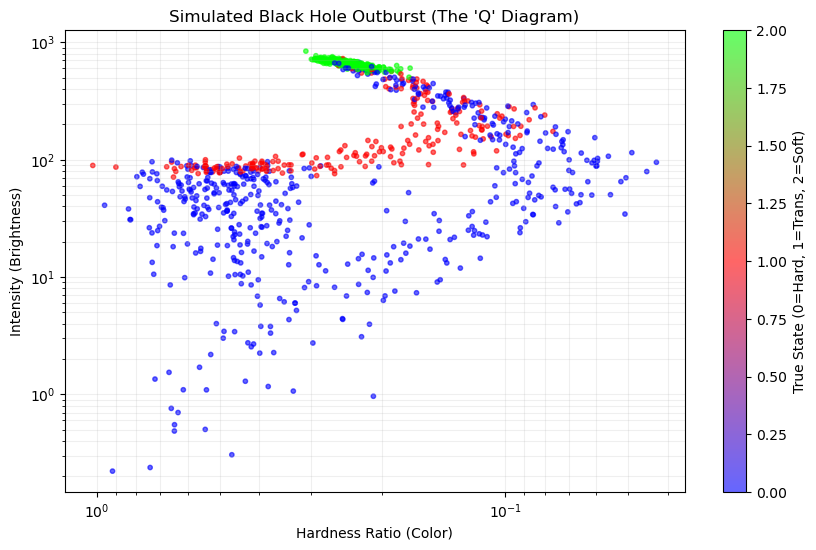

In [4]:
# 3. Run and Visualize

X_spectra, y_states, h_ratio, intensity = generate_outburst_data(n_days=1000)

plt.figure(figsize=(10, 6))
# This is the famous "HID" (Hardness-Intensity Diagram)
scatter = plt.scatter(h_ratio, intensity, c=y_states, cmap='brg', s=10, alpha=0.6)
plt.gca().invert_xaxis() # Astronomers always put Hard on the right, Soft on the left
plt.yscale('log')
plt.xscale('log')
plt.title("Simulated Black Hole Outburst (The 'Q' Diagram)")
plt.xlabel("Hardness Ratio (Color)")
plt.ylabel("Intensity (Brightness)")
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.colorbar(scatter, label='True State (0=Hard, 1=Trans, 2=Soft)')
plt.show()

In [5]:
# Performing the K-Means Clustering

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [6]:
#. Pre-processing

# We want to cluster based on SHAPE (Color), not Brightness.
# So we normalize each row so it sums to 1.
# This forces the AI to look at the relative ratio of Hard vs Soft photons.
X_normalized = X_spectra / np.sum(X_spectra, axis=1, keepdims=True)

# Optional: Log scale helps if values span orders of magnitude, 
# but row-normalization is usually enough for spectral shapes.

In [7]:
# Doing the K-Means

print("Asking AI to find 3 natural clusters in the physics data...")
# We pick k=3 because we expect (Hard, Soft, Intermediate)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans.fit(X_normalized)

# Get the labels the AI assigned (0, 1, or 2)
ai_labels = kmeans.labels_

Asking AI to find 3 natural clusters in the physics data...


D:\zz - Rizchel\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


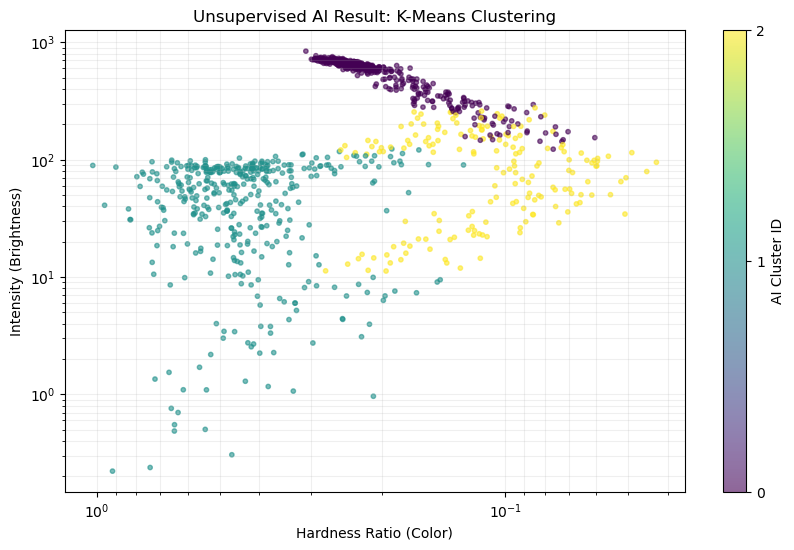

In [8]:
# 3. Visualization: The HID with AI Labels
plt.figure(figsize=(10, 6))

# We plot the same Hardness-Intensity Diagram, but color it with AI LABELS
scatter = plt.scatter(h_ratio, intensity, c=ai_labels, cmap='viridis', s=10, alpha=0.6)

plt.gca().invert_xaxis() # Standard Astronomy convention
plt.yscale('log')
plt.xscale('log')

plt.title("Unsupervised AI Result: K-Means Clustering")
plt.xlabel("Hardness Ratio (Color)")
plt.ylabel("Intensity (Brightness)")
plt.grid(True, which="both", ls="-", alpha=0.2)

# Create a custom legend
cbar = plt.colorbar(scatter, ticks=[0, 1, 2])
cbar.set_label('AI Cluster ID')

plt.show()

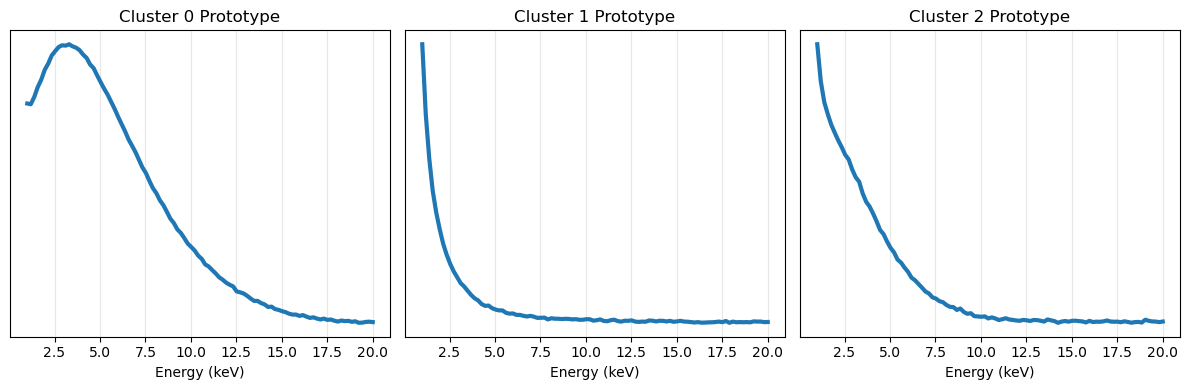

In [9]:
# 4. Validation (Centroids)
# Let's look at the "Average Spectrum" for each cluster to see what the AI found.
plt.figure(figsize=(12, 4))
energies = np.linspace(1, 20, 100)

for i in range(3):
    plt.subplot(1, 3, i+1)
    # Plot the centroid (the 'concept' of the cluster)
    plt.plot(energies, kmeans.cluster_centers_[i], linewidth=3)
    plt.title(f"Cluster {i} Prototype")
    plt.xlabel("Energy (keV)")
    plt.yticks([]) # Hide y-axis scale
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [10]:
from sklearn.decomposition import PCA

# 1. Run PCA
# We use the normalized data (Shape only)
print("Projecting 100-dimensional X-ray data down to 2D...")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_normalized)

# How much information did we keep?
explained_variance = pca.explained_variance_ratio_
print(f"Explained Variance: PC1={explained_variance[0]:.2%}, PC2={explained_variance[1]:.2%}")
print(f"Total Info Retained: {sum(explained_variance):.2%}")

Projecting 100-dimensional X-ray data down to 2D...
Explained Variance: PC1=79.10%, PC2=5.86%
Total Info Retained: 84.95%


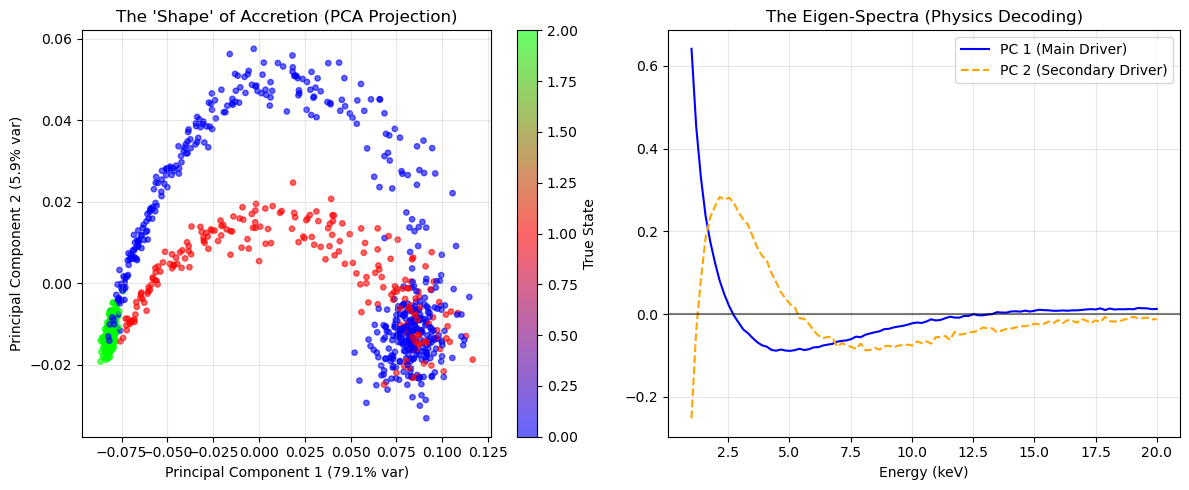

In [11]:
# 2. Visualization: The "Data Manifold" ---
plt.figure(figsize=(12, 5))

# Plot 1: The PCA Map (PC1 vs PC2)
plt.subplot(1, 2, 1)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_states, cmap='brg', s=15, alpha=0.6)
plt.xlabel(f"Principal Component 1 ({explained_variance[0]:.1%} var)")
plt.ylabel(f"Principal Component 2 ({explained_variance[1]:.1%} var)")
plt.title("The 'Shape' of Accretion (PCA Projection)")
plt.grid(True, alpha=0.3)
plt.colorbar(scatter, label='True State')

# Plot 2: What do the Components actually mean? (The Eigenvectors)
plt.subplot(1, 2, 2)
energies = np.linspace(1, 20, 100)
plt.plot(energies, pca.components_[0], label='PC 1 (Main Driver)', color='blue')
plt.plot(energies, pca.components_[1], label='PC 2 (Secondary Driver)', color='orange', linestyle='--')
plt.axhline(0, color='black', alpha=0.5)
plt.title("The Eigen-Spectra (Physics Decoding)")
plt.xlabel("Energy (keV)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()